Formateo los datos

In [12]:
import pandas as pd


def format_pd(data, intento):

    data = data[data["Intento"] == intento].copy() 

    # Esto es para que arranque en 365 una vez (lo hizo chat obviamente)
    mask = (data['x'] != 365.00) | (data['x'].shift(-1) != 365.00)

    data = data[mask]

    # Arranca en t = 0
    data["t"] = data["t"] - data["t"].min()

    data = data.drop(columns=["Intento"])
    
    return data

Este lo chorie del campus

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

datasets = ['data_dosplata_oro_PAPEL.csv', 'data_dosplataymadera_oro.csv', 'data_maderayoro_dosplata.csv', 'data_plata_dosplata.csv', 'data_tresplata_oro_PAPEL.csv' ] 
data = pd.read_csv(datasets[1])
f_data = format_pd(data=data, intento=1)

In [15]:
def f_propagacion_errores(t, popt, error_x):

    a, b, c = popt

    sum = 0
    for i in range(len(t)):
        df_dx = 2 * i * a + b
        sum += df_dx**2 * error_x**2

    return np.sqrt(sum)

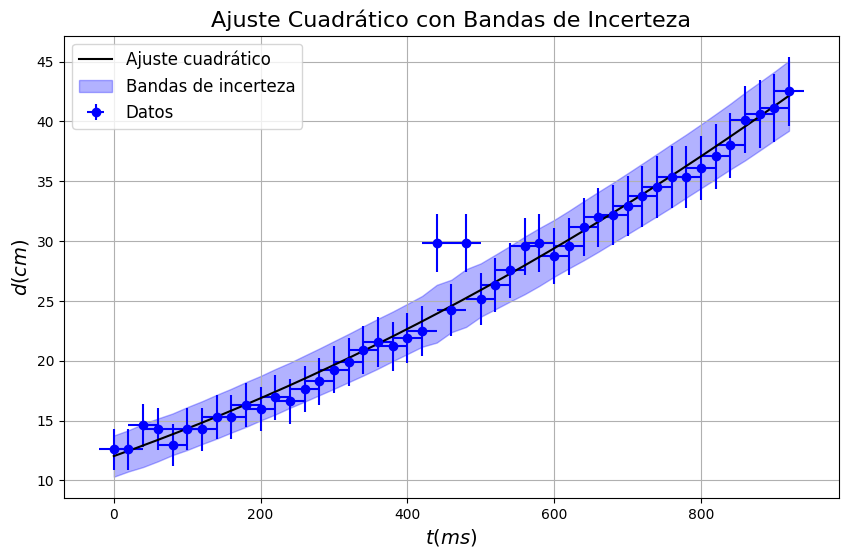

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def modelo_cuadratico(t, a, b, c):
    return a * t**2 + b * t + c

# FUNCIONES SACADAS DE CALIBRACIÓN

def distancia(v):
    return 0.0178*v - 1.2753

def sigma_d(v):
    return 0.0007*v + 1.1673

def f_propagacion_errores(t, popt, errores_x):
    """
    Function to propagate the errors based on the fit parameters and x-axis errors.
    
    Parameters:
    t (array-like): Independent variable (time) data points
    popt (array-like): Fitted parameters from curve_fit
    errores_x (array-like): Error values for the independent variable data points (x-axis)
    
    Returns:
    sigma_d_t (array-like): Propagated uncertainty in the dependent variable (y-axis)
    """
    a, b, c = popt
    # Error propagation formula for quadratic fit
    sigma_d_t = np.sqrt((2 * a * t + b) ** 2 * errores_x ** 2)
    return sigma_d_t

# Example data
tiempo = f_data["t"].values
posicion = distancia(f_data["x"].values)
errores_y = sigma_d(f_data["x"].values)
errores_x = 20

# Fit the quadratic model to the data
popt, pcov = curve_fit(modelo_cuadratico, tiempo, posicion, sigma=errores_y, absolute_sigma=True)

# Extract the fitted parameters and their uncertainties
a, b, c = popt
errores = np.sqrt(np.diag(pcov))

# Propagate errors
sigma_d_t = f_propagacion_errores(tiempo, popt, errores_x)

# Create a smoother time range for plotting the fitted curve
t_ajuste = np.linspace(min(tiempo), max(tiempo), 500)

# Plotting
plt.figure(figsize=(10, 6))

# Plot the data points with error bars on both axes
plt.errorbar(tiempo, posicion, xerr=errores_x, yerr=errores_y, fmt='o', color='blue', label='Datos')

# Plot the quadratic fit
plt.plot(t_ajuste, modelo_cuadratico(t_ajuste, *popt), 'black', label='Ajuste cuadrático')

# Plot the uncertainty bands
plt.fill_between(tiempo, modelo_cuadratico(tiempo + sigma_d_t, *popt) + errores_y, 
                 modelo_cuadratico(tiempo - sigma_d_t, *popt) -errores_y, color='blue', alpha=0.3, label='Bandas de incerteza')

# Customize the plot
plt.xlabel(r'$t(ms)$', fontsize=14)
plt.ylabel(r'$d(cm)$', fontsize=14)
plt.title('Ajuste Cuadrático con Bandas de Incerteza', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Display the plot
plt.show()
